## Making training and test data 

In this notebook it is explained step by step the procedure to create the simulated HRTEM images used for training and test the neural network. 
- The wulff_construction module of the atomic simulation environment (ASE) is used to create the atomic model with random parameters, such as the number of atoms in the structure and the orientations. 
- The PyQSTEM library is used to simulate the corresponding high resolution transmission electron microscopy (HRTEM)image with random values of the microscope parameters (spherical aberration, defocus, focal spread etc.)

The random values of the input parameters in both the atomic models and the simulated HRTEM image are necessary to create a moltitude of different data to properly train and thest the neural network. This notebook allows to visulize the results obtaine by the corresponding make_data.py. For simplicity, here it is shown the creation of a single image, but in make_data.py one can create many images depending on the specific need for training and testing the neural network. For our case, 8000 ands 2000 images have been considered to train and test the model.

The simulated images and the corresponding labels should be saved in the folders 'data/training/images/', 'data/training/labels/' for the training and 'data/test/images/','data/test/labels/' for the test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.cluster import wulff_construction
from make_random_nanoparticles import get_random_atomic_model
from ase.visualize import view
import pyqstem
from pyqstem.imaging import CTF
from pyqstem import PyQSTEM
from data_augmentation import local_normalize,random_flip,random_contrast,random_brightness,random_blur,random_gamma,random_flip
from make_label import make_label

Input:

- surfaces: surface orientation of the simulated metallic nanoparticles. Depending on the purpose,particles with different surface orientation can be mixed or used separately in the training process. The user can include as many configurations in order to train a model which can work for any orientation depending on the needs. In our case we have considered [1,0,0],[1,1,0],[1,1,1] because these are the surface orientations of the nanoparticles in the experimental HRTEM images.


- esurf: surface energies in [J/m^2] of the considered surface orientations. The surface energies are derived from density functional theory (DFT) calculations.


- n_min_atoms,n_max_atoms: range of the random number of atoms considered in the structure. A different number of atoms corresponds to different column heights.


- lc: lattice constant


- random_alpha: the structure is rotated of a random angle chosen randomly in a pre-defined set. The rotation of the structure leads to the exposure of a particular surface orientation, resulting in a different number of atoms in the atomic columns. Rotations angles of 0 and 45 degree have been set for the x an z axis. [1 0 0] orientation corresponds to rotation angle of 0 degree for both the x and z axis, [1 1 0] orientation for a 45 degree angle around the x axis and 0 degree angle around the z axis (or viceversa) and [1 1 1] for a rotation angle of 45 degree for both the x and z axis.


- qstem: PyQSTEM module used in TEM mode


- img_size: size of the simulated image. Here it is used 256 pixels, but the neural network is flexible to any value equal to $2^{n}$ where *n* is the number of pooling layers in the network.


- random_sampling: resolution of the simulated HRTEM image. The sampling is simply the ratio between the length scale in A of the content represented in the simulated image and the image size. Here a random lenght scale of 65 $ ^{+}_{-}$ lamda A is used, where lamda is a random value between 0 and 2 A. As a result, a sampling range  between 0.256 and 0.265 is considered


- cell_size: length scale in A of the represented content

In [2]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
esurf = [6, 2, 4]   
#surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1),(2,1,0),(2,1,1),(2,2,1),(3,1,0),(3,1,1),(3,2,0),(3,2,1),(3,2,2),(3,3,1),(3,3,2)]
#esurf = [6, 2, 4,1,2,8,1,7,1,5,5,3,5]  (from DFT calculations)
lc = 4.08

n_min_atoms=100
n_max_atoms=2000

random_alpha=[[0,0],[45,0],[45,45]]

qstem=PyQSTEM('TEM')

img_size=256
random_sampling = np.random.uniform(low=0.250,high=0.265,size=1)[0]
cell_size=random_sampling*img_size

Creation of the atomic model:

- random_size: a random number of atoms is considered
- atomic_model: atomic model of a gold nanoparticle is created using the wulff_construction module of ASE.
- random_index: index for picking a random rotation angle around the x and z axis
- atomic_model.rotate: rotation of the simulated structure


In [3]:
random_size = np.random.randint(low=n_min_atoms,high=n_max_atoms)  # Number of atoms

atomic_model= wulff_construction('Au', surfaces, esurf,
                           random_size, 'fcc',
                           rounding='above', latticeconstant=lc)

random_rotation=np.random.randint(len(random_alpha),size=1)[0]

alpha_x=random_alpha[random_rotation][0]
alpha_z=random_alpha[random_rotation][1]

atomic_model.rotate(v='x',a=alpha_x,center='COP')
atomic_model.rotate(v='z',a=alpha_z,center='COP')
np.random.uniform(-10,10)
atomic_model.set_cell((cell_size,)*3)

atomic_model.center()

lx=np.random.uniform(-cell_size/6,cell_size/6)
ly=np.random.uniform(-cell_size/6,cell_size/6)

atomic_model.translate([lx,ly,0])

print('atomic model rotatated by '+str(alpha_x) +' degree around the x axis')
print('atomic model rotatated by '+str(alpha_z) +' degree around the z axis')
print('')

if alpha_x==0 and alpha_z==0:
    print('exposed surface: [1 0 0]')
if alpha_x==45 and alpha_z==0:    
    print('exposed surface: [1 1 0]')
    np.random.uniform(-10,10)
if alpha_x==45 and alpha_z==45:
    print('exposed surface: [1 1 1]')

atomic model rotatated by 45 degree around the x axis
atomic model rotatated by 45 degree around the z axis

exposed surface: [1 1 1]


In order to create stuctures with random insertion of atoms, the function 'get_random_atomic_model' fom 'make_random_nanoparticles' can be used. The size of the random structure can be changed by tuning the parameter random_size.

In [4]:
atomic_model=get_random_atomic_model(element='Au',random_size=np.random.randint(6,10),cell_size=cell_size)

Visualize the atomic model:

In [5]:
view(atomic_model)

Simulation of the exit wave function of the microsope

In [6]:
wave_size=(int(atomic_model.get_cell()[0,0]/random_sampling),int(atomic_model.get_cell()[1,1]/random_sampling))
qstem.set_atoms(atomic_model)
qstem.build_wave('plane',300,wave_size)
qstem.build_potential(int(atomic_model.get_cell()[2,2]*2))
qstem.run()
wave=qstem.get_wave()
wave.array=wave.array.astype(np.complex64)

Generation of the contrast transfer function (CTF) and modular transfer function (MTF) used to artificially reproduce the TEM process to form an image. The values of the microscope parameters are in agreement with the experimental conditions and they are summarized in Table 1 in the manuscript.

In [7]:
Cs = np.random.uniform(low=-20*1e4,high=20*1e4,size=1)[0]

defocus=np.random.uniform(low=-250,high=-150,size=1)[0]

focal_spread=np.random.uniform(low=20,high=40,size=1)[0]

aberrations={'a22' : np.random.uniform(low=0,high=50,size=1)[0],
                 'phi22' :  np.random.uniform(low=0,high=2*np.pi,size=1)[0]}
 
ctf=CTF(defocus=defocus,Cs=Cs,focal_spread=focal_spread,aberrations=aberrations)

blur= np.random.uniform(low=0,high=2,size=1)[0]

dose=np.random.uniform(low=1e2,high=1e3,size=1)[0]

c1=np.random.uniform(low=0.95,high=1,size=1)[0]

c2=np.random.uniform(low=0,high=1e-2,size=1)[0]

c3=np.random.uniform(low=5e-1,high=6e-1,size=1)[0]

c4=c1=np.random.uniform(low=2,high=3,size=1)[0]

MTF_param=[c1,c2,c3,c4]

image=wave.apply_ctf(ctf).detect(resample=random_sampling,blur=blur,dose=dose,MTF_param=MTF_param)


Label:

In [8]:
label=make_label(atomic_model,random_sampling,(img_size,)*2,width=2)

Data augmentation is applied to generate images with different brightneesm contrast, blur etc. Random parameters are used to create a broad dataset of simulated images with combinations of dirrent imaging conditions.

In [9]:
image=local_normalize(image,12/random_sampling,12/random_sampling)

image=random_brightness(image,-0.1,0.1)

image=random_contrast(image,0.9,1.1)

image=random_gamma(image,0.9,1.1)

image=random_blur(image,0.9,1.1)

image,label=random_flip(image,label,0,1)


Visualizing the simulated HRTEM image

(-0.5, 255.5, 255.5, -0.5)

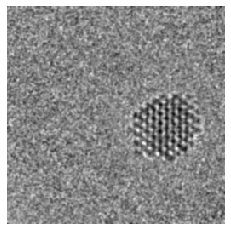

In [10]:
plt.imshow(image[:,:],cmap='gray')
plt.axis('off')

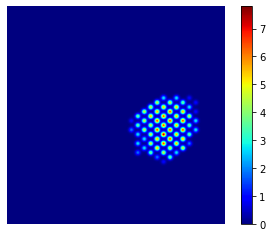

In [11]:
plt.imshow(label,cmap='jet',interpolation='Gaussian')
plt.axis('off')
plt.colorbar()